In [1]:
#princess.pyをダウンロードしてから以下を実行してください。
from google.colab import files
uploaded = files.upload()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import chainer.optimizers as Opt
import chainer.functions as F
import chainer.links as L
import chainer.datasets as ds
import chainer.dataset.convert as con
from chainer.iterators import SerialIterator as siter
from chainer import optimizer_hooks as oph
from chainer import Variable,Chain,config,cuda

from tqdm import tqdm
from IPython import display

import princess as ohm

In [ ]:
ohm.download_fig()

In [2]:
all_list = []
ohm.add_labeled_data("princess_fig",0,all_list)
dataset = ds.LabeledImageDataset(all_list)
dataset = ds.TransformDataset(dataset, ohm.labeled64)
D = len(dataset)
trainA, testA = ds.split_dataset_random(dataset, D//2)

In [3]:
all_list = []
ohm.add_labeled_data("white_fig",1,all_list)
dataset = ds.LabeledImageDataset(all_list)
dataset = ds.TransformDataset(dataset, ohm.labeled64)
D = len(dataset)
trainB, testB = ds.split_dataset_random(dataset,D//2)

In [4]:
xtrainA,_ = con.concat_examples(trainA)
xtestA,_ = con.concat_examples(testA)
xtrainB,_ = con.concat_examples(trainB)
xtestB,_ = con.concat_examples(testB)

In [5]:
DtrainA,ch,Ny,Nx = xtrainA.shape
DtestA = len(xtestA)
print(DtrainA,DtestA,ch,Ny,Nx)
DtrainB,ch,Ny,Nx = xtrainB.shape
DtestB = len(xtestB)
print(DtrainB,DtestB,ch,Ny,Nx)

10 11 3 64 64
6 6 3 64 64


In [6]:
class Generator(Chain):
    def __init__(self,ch=ch, H1=64,H2=128,H3=256,H4=512):
        layers = {}
        layers['cnn1'] = ohm.CBR(ch, H1,"down")
        layers['cnn2'] = ohm.CBR(H1, H2,"down")
        layers['cnn3'] = ohm.CBR(H2, H3,"down")
        layers['cnn4'] = ohm.CBR(H3, H4,"down")
        layers["l1"]= L.Linear(H4*4*4,H4*4*4)
        layers["bnorm1"]= L.BatchNormalization(H4*4*4)
        layers['dcnn1'] = ohm.CBR(H4, H3,"up")
        layers['dcnn2']= ohm.CBR(H3, H2,"up")
        layers['dcnn3']= ohm.CBR(H2, H1,"up")
        layers['dcnn4']= ohm.CBR(H1, ch,"up")
    #layers['Rb3'] = ResBlock(ch*64)
        super().__init__(**layers)
    def __call__(self,x):
        h = self.cnn1(x)
        h = self.cnn2(h)
        h = self.cnn3(h)
        h = self.cnn4(h)
        h = self.l1(h)
        h = self.bnorm1(h)
        h = F.relu(h)
        h = h.reshape(len(h),512,4,4)
        h = self.dcnn1(h) 
        h = self.dcnn2(h) 
        h = self.dcnn3(h) 
        h = self.dcnn4(h)
        y = F.clip(h,0.0,1.0)
        return y

In [7]:
class Discriminator(Chain):
    def __init__(self, C, ch = ch,H1=64,H2=128,H3=256,H4=512):
        layers = {}
        layers['cnn1'] = ohm.CBR(ch,H1,"down",bn=False,
                                                      act=F.leaky_relu)
        layers['cnn2'] = ohm.CBR(H1,H2,"down",bn=False,
                                                      act=F.leaky_relu)
        layers['cnn3'] = ohm.CBR(H2,H3,"down",bn=False,
                                                      act=F.leaky_relu)
        layers['cnn4'] = ohm.CBR(H3,H4,"down",bn=False,
                                                      act=F.leaky_relu)
        layers['l1'] = L.Linear(None,C)
        super().__init__(**layers)
    def __call__(self,x):
        h = self.cnn1(x)
        h = self.cnn2(h)
        h = self.cnn3(h)
        h = self.cnn4(h)
        h = self.l1(h)
        y = F.dropout(h)
        return y

In [8]:
gen_AtoB = Generator()
gen_BtoA = Generator()

In [9]:
C = 1
dis_A = Discriminator(C)
dis_B = Discriminator(C)

In [10]:
optgen_AtoB = Opt.Adam(alpha=0.0005, beta1=0.5)
optgen_AtoB.setup(gen_AtoB)
optgen_AtoB.target.cleargrads()
optgen_BtoA = Opt.Adam(alpha=0.0005, beta1=0.5)
optgen_BtoA.setup(gen_BtoA)
optgen_BtoA.target.cleargrads()
optdis_A = Opt.Adam(alpha=0.0001, beta1=0.5)
optdis_A.setup(dis_A)
optdis_A.target.cleargrads()
optdis_B = Opt.Adam(alpha=0.0001, beta1=0.5)
optdis_B.setup(dis_B)
optdis_B.target.cleargrads()

#optgen_AtoB.add_hook(oph.GradientClipping(0.1))
#optgen_AtoB.add_hook(oph.WeightDecay(0.00001))
#optgen_BtoA.add_hook(oph.GradientClipping(0.1))
#optgen_BtoA.add_hook(oph.WeightDecay(0.00001))
#optdis_A.add_hook(oph.GradientClipping(0.1))
#optdis_A.add_hook(oph.WeightDecay(0.00001))
#optdis_B.add_hook(oph.GradientClipping(0.1))
#optdis_B.add_hook(oph.WeightDecay(0.00001))

cuda.get_device(3).use()
gen_AtoB.to_gpu()
gen_BtoA.to_gpu()
dis_A.to_gpu()
dis_B.to_gpu()

In [11]:
train_gen_loss_A = []
train_dis_loss_A1 = []
train_dis_loss_A2 = []
train_gen_loss_B = []
train_dis_loss_B1 = []
train_dis_loss_B2 = []
resultA = [train_gen_loss_A,train_dis_loss_A1,train_dis_loss_A2]
resultB = [train_gen_loss_B,train_dis_loss_B1,train_dis_loss_B2]

 10%|▉         | 99/1000 [01:28<13:02,  1.15it/s]

epoch 100


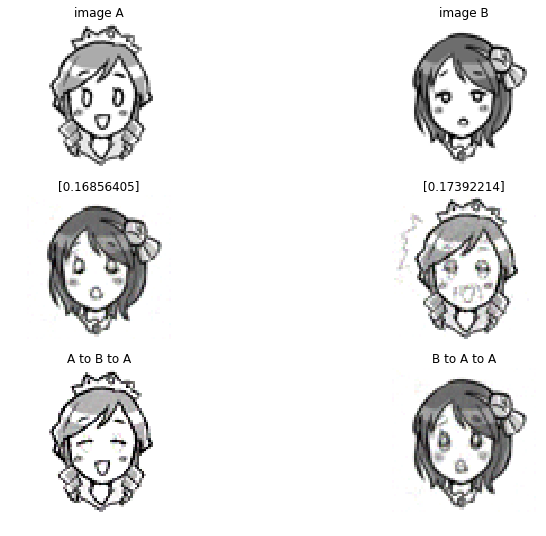

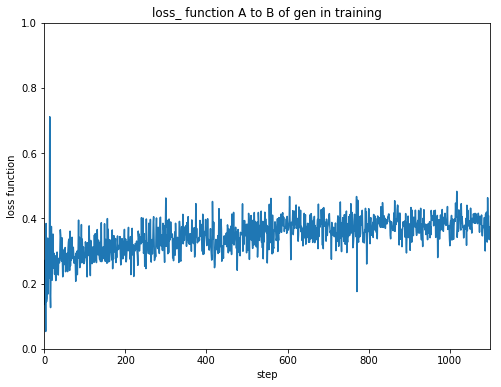

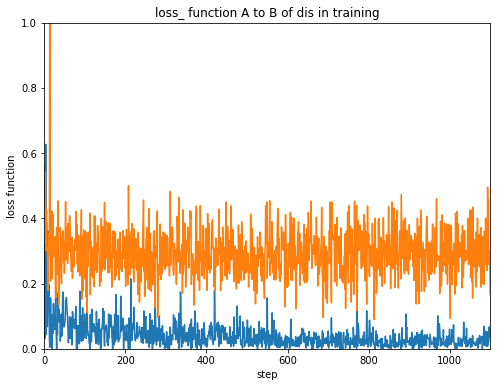

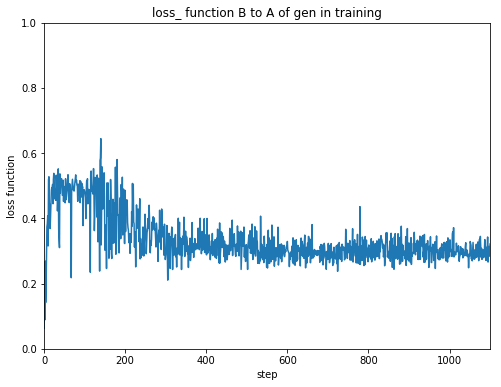

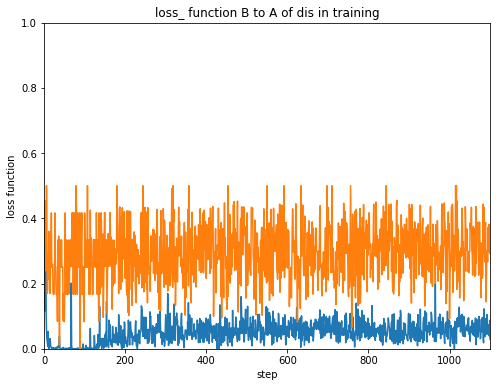

 20%|█▉        | 199/1000 [03:00<12:14,  1.09it/s]

epoch 200


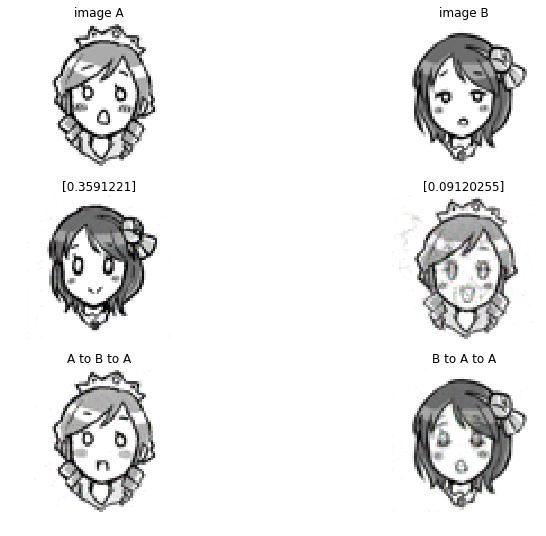

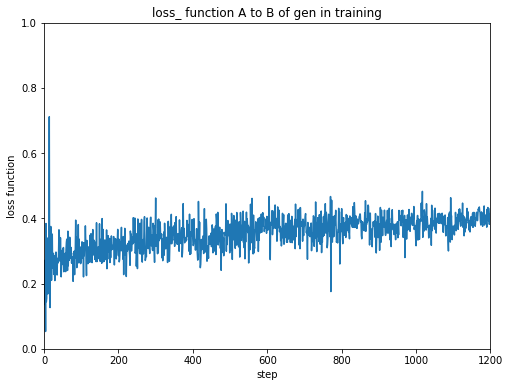

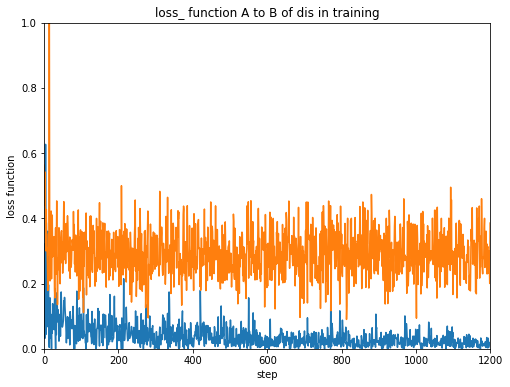

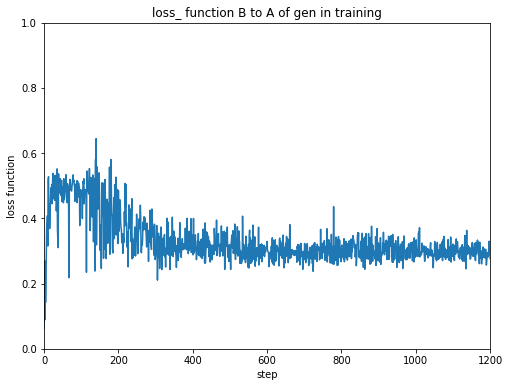

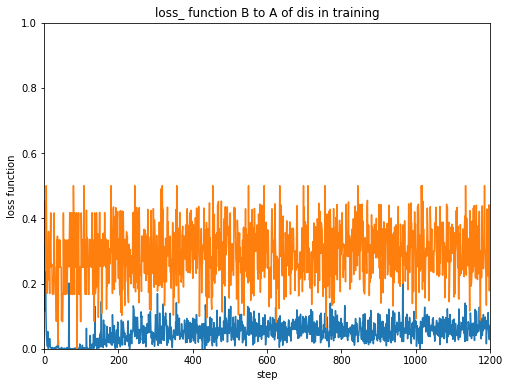

 30%|██▉       | 299/1000 [04:32<10:43,  1.09it/s]

epoch 300


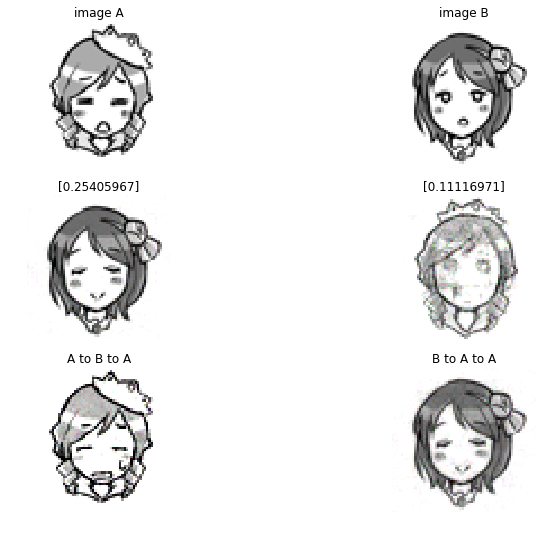

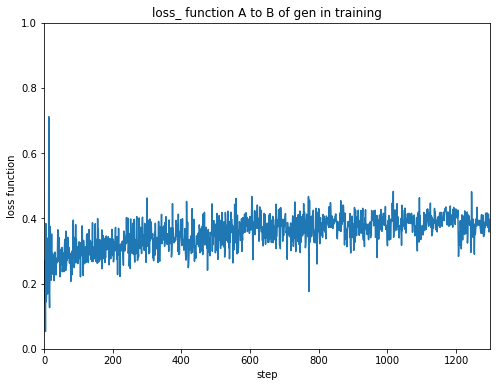

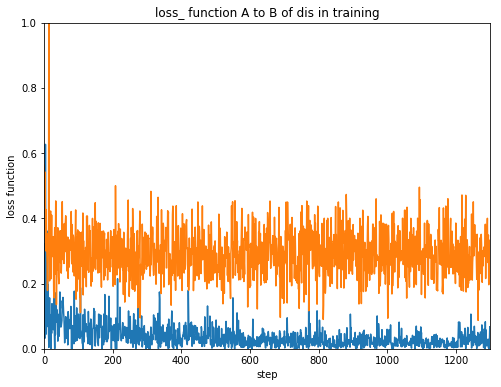

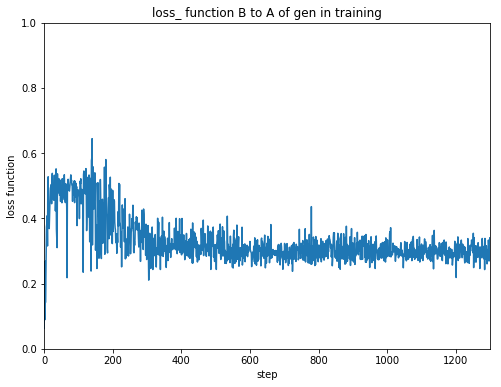

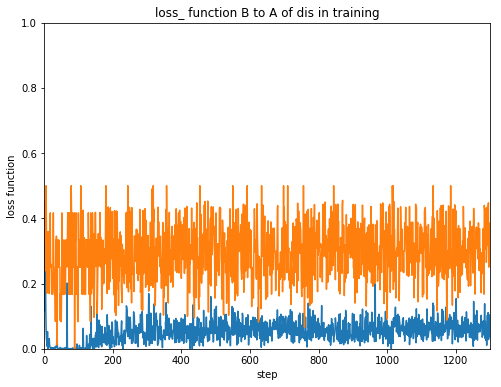

 40%|███▉      | 399/1000 [06:05<09:22,  1.07it/s]

epoch 400


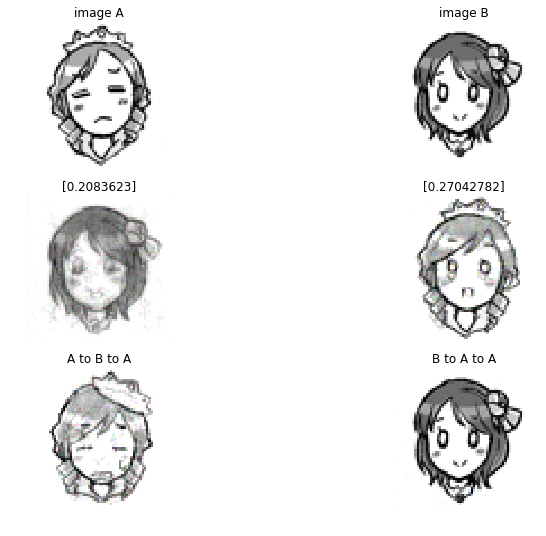

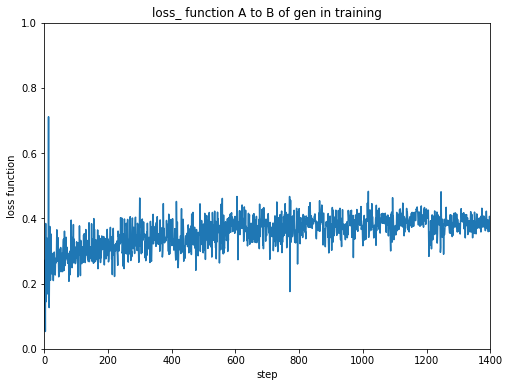

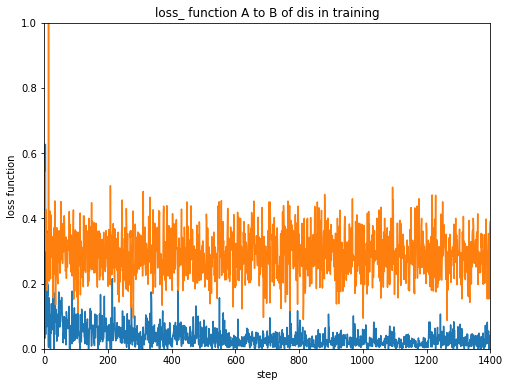

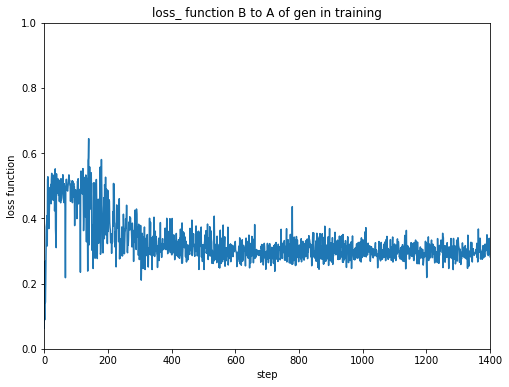

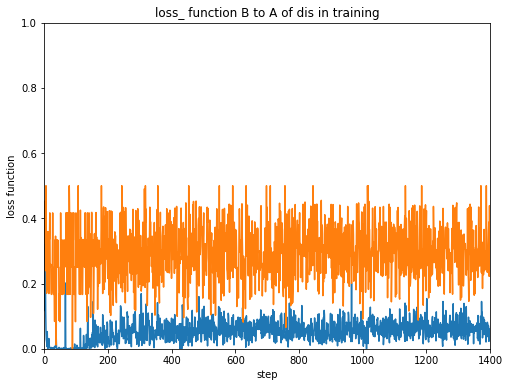

 50%|████▉     | 499/1000 [07:39<07:43,  1.08it/s]

epoch 500


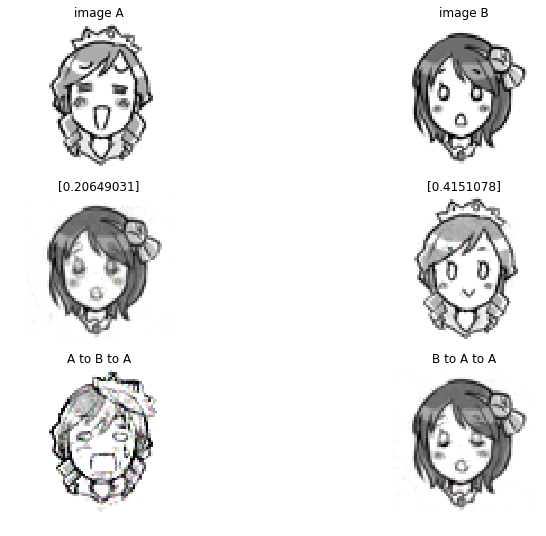

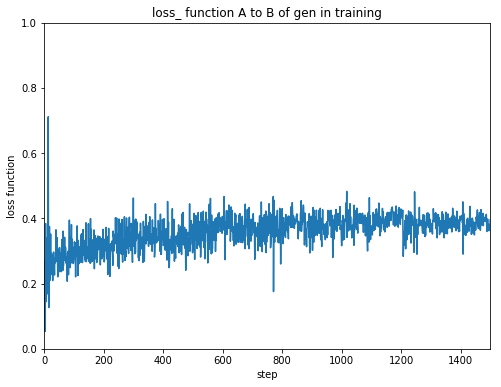

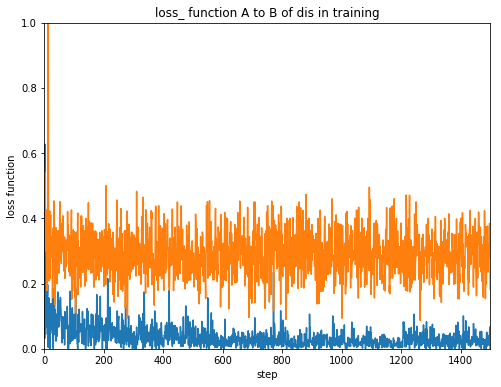

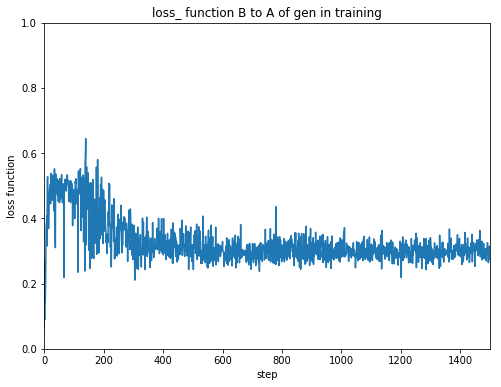

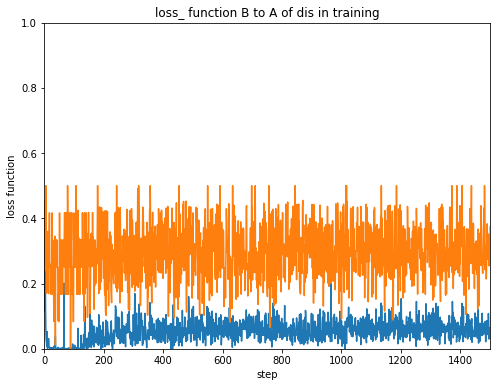

 60%|█████▉    | 599/1000 [09:12<06:02,  1.11it/s]

epoch 600


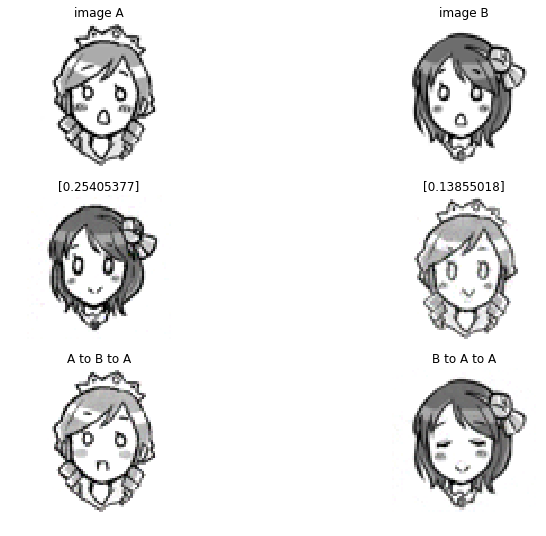

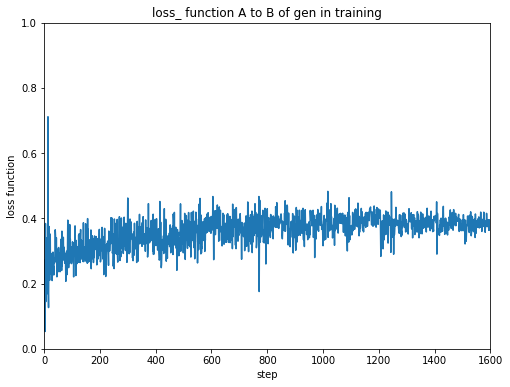

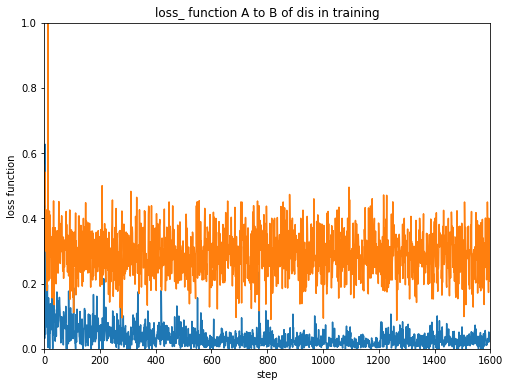

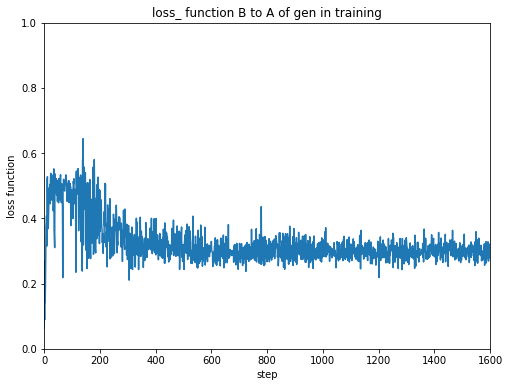

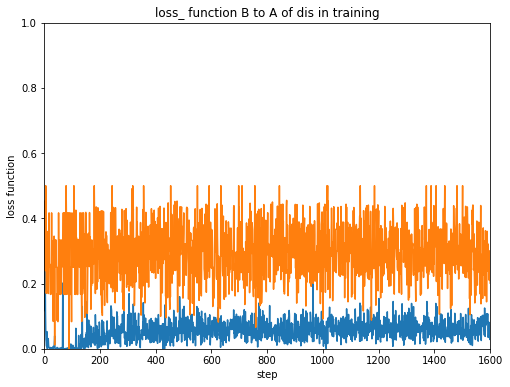

 70%|██████▉   | 699/1000 [10:43<04:29,  1.12it/s]

epoch 700


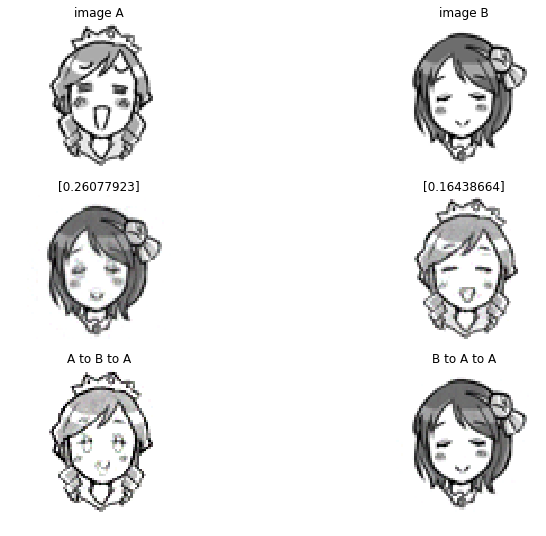

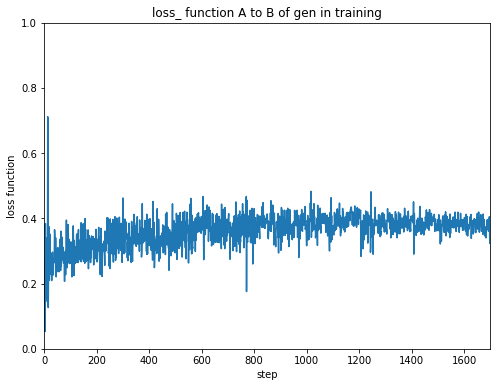

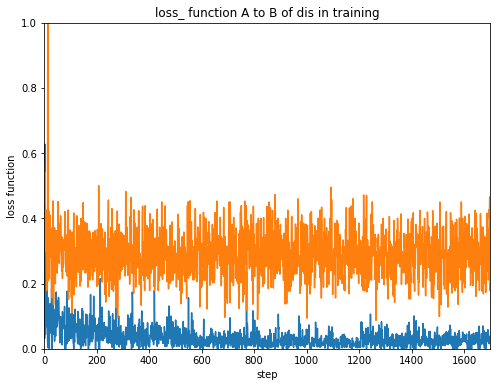

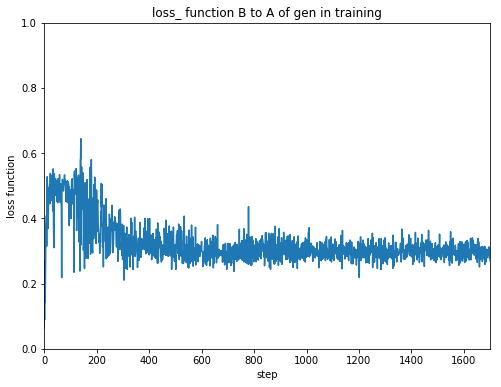

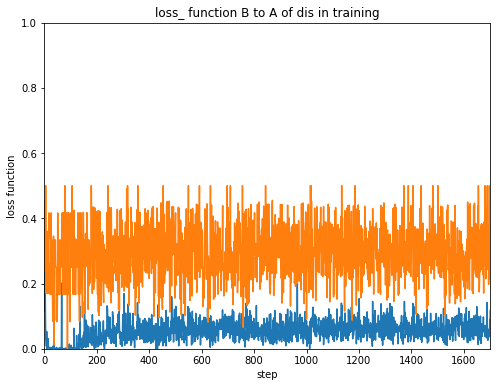

 80%|███████▉  | 799/1000 [12:14<02:59,  1.12it/s]

epoch 800


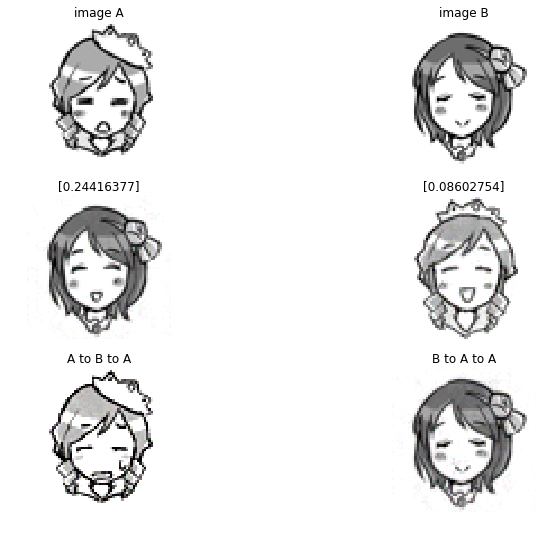

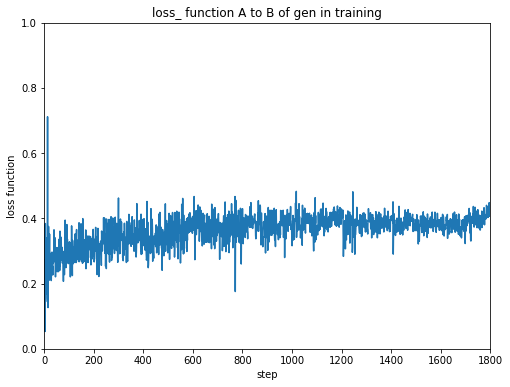

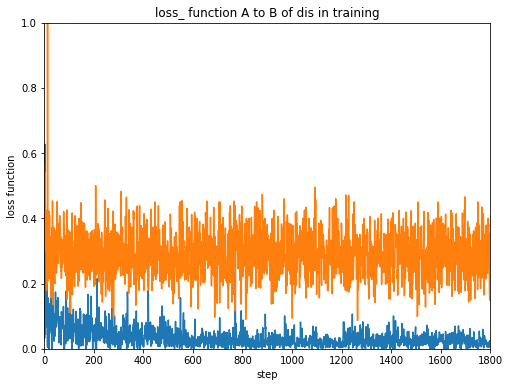

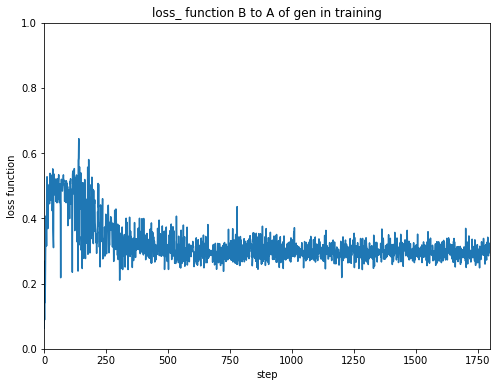

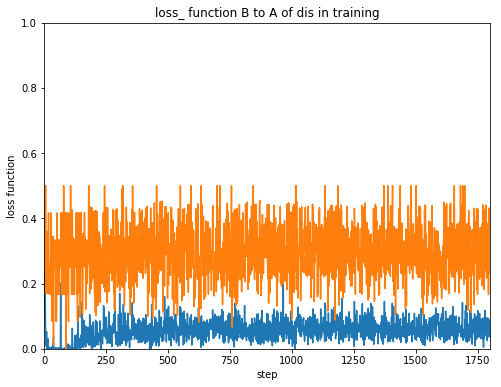

 90%|████████▉ | 899/1000 [13:46<01:30,  1.12it/s]

epoch 900


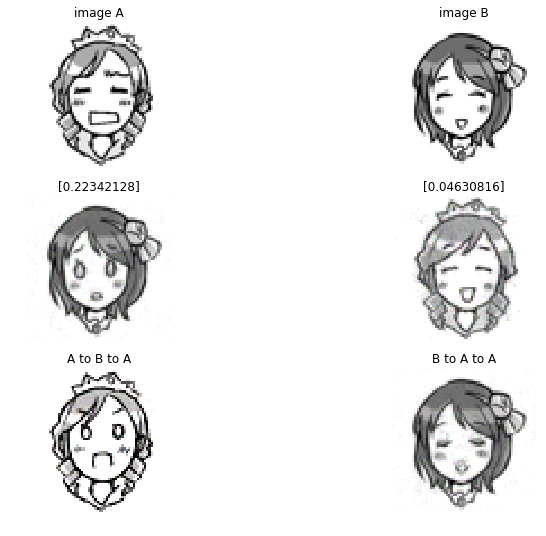

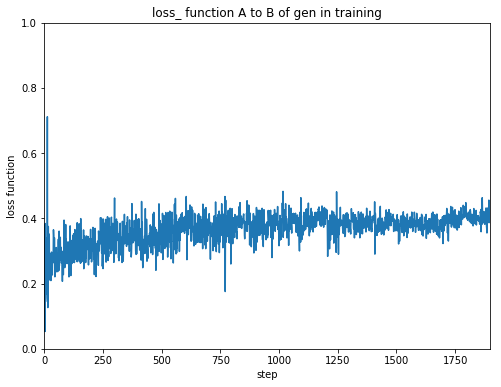

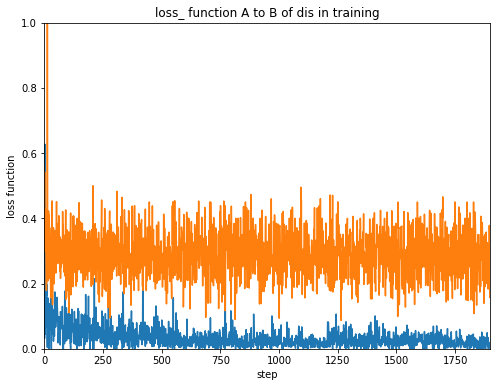

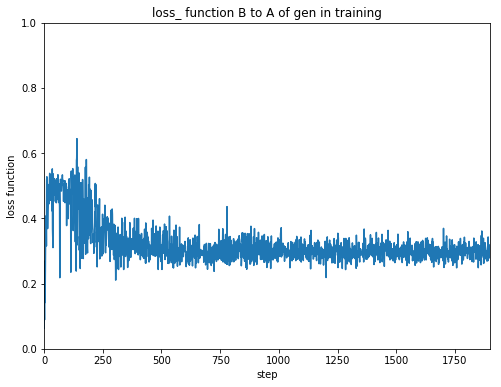

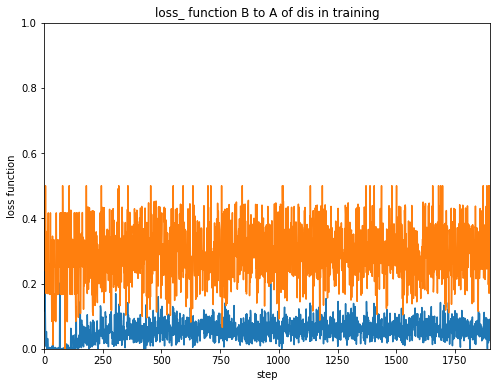

100%|█████████▉| 999/1000 [15:16<00:00,  1.11it/s]

epoch 1000


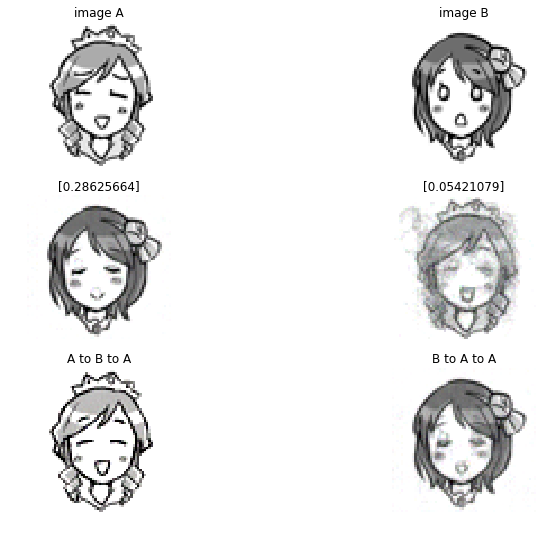

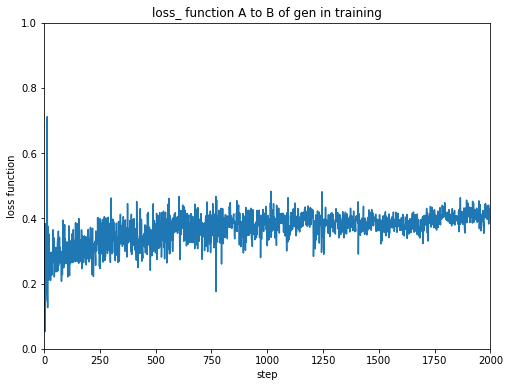

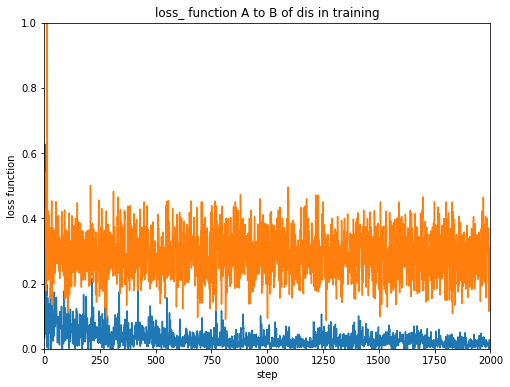

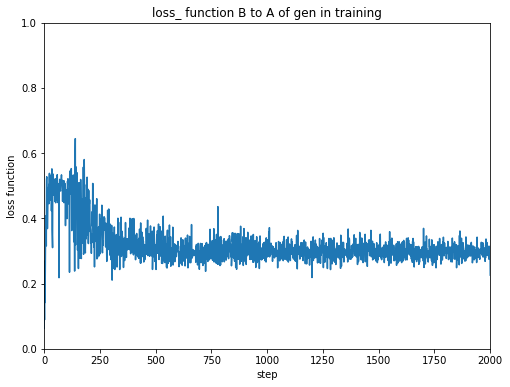

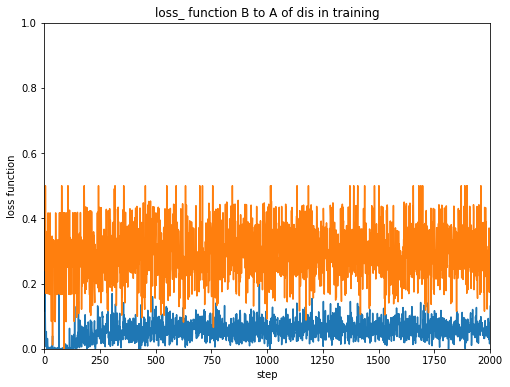

In [15]:
output_folder = 'output_princess'
nepoch = 1000
batch_size = 10
train_iter_A = siter(trainA, batch_size)
train_iter_B = siter(trainB, batch_size)
with tqdm(total = nepoch) as pbar:
    while train_iter_A.epoch < nepoch:
        pbar.update(train_iter_A.is_new_epoch)
        batchA = train_iter_A.next()
        batchB = train_iter_B.next()
        xtrainA,_ = con.concat_examples(batchA)        
        xtrainB,_ = con.concat_examples(batchB)
        dataBA = cuda.to_gpu([xtrainB,xtrainA])
        ohm.learning_L1(gen_BtoA,gen_AtoB,optgen_BtoA,optgen_AtoB,dataBA,T = 5)
        ohm.learning_consist(gen_BtoA,gen_AtoB,optgen_BtoA,optgen_AtoB,dataBA,T = 5)
        ohm.learning_GAN(gen_AtoB,dis_B,optgen_AtoB,optdis_B,dataBA,resultB,T=5)            
        dataAB = cuda.to_gpu([xtrainA,xtrainB])
        ohm.learning_GAN(gen_BtoA,dis_A,optgen_BtoA,optdis_A,dataAB,resultA,T=5)            
        if train_iter_A.epoch%100 == 0:
            ohm.temp_image2(train_iter_A.epoch,output_folder+'/test',xtestA,xtestB,gen_AtoB,gen_BtoA,dis_A,dis_B)
            ohm.plot_result(resultA[0],'loss_ function A to B of gen in training','step','loss function',0.0,1.0)            
            ohm.plot_result2(resultA[1],resultA[2],'loss_ function A to B of dis in training','step','loss function',0.0,1.0)            
            ohm.plot_result(resultB[0],'loss_ function B to A of gen in training','step','loss function',0.0,1.0)            
            ohm.plot_result2(resultB[1],resultB[2],'loss_ function B to A of dis in training','step','loss function',0.0,1.0)            
            
ohm.save_model(gen_AtoB,output_folder+'/gen_AtoB')
ohm.save_model(gen_BtoA,output_folder+'/gen_BtoA')
ohm.save_model(dis_A,output_folder+'/dis_A')
ohm.save_model(dis_B,output_folder+'/dis_B')